Load Video

1.   Load from Google Drive in Colab
2.   Make directory



In [33]:
!ls drive/FaceClustering

lbpcascade_frontalface_improved.xml  WINNER_EVERYDAY.mp4


In [19]:
# Google Colab import files in google drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
!cd drive; ls; 

gpg: keybox '/tmp/tmpw9gv7ppf/pubring.gpg' created
gpg: /tmp/tmpw9gv7ppf/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
4월 27일 JUNO 한강 스터디.zip  FaceClustering		      Windows10
ColabNotebooks		       웹크롤러 추가 기능 제안서.ods
Colab Notebooks		       학점시발.ods


In [1]:
!pip install tqdm
from tqdm import tqdm
import cv2 as cv
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt

In [0]:
VIDEO_DIR = 'drive/FaceClustering/'
VIDEO_FILE_NAME = 'WINNER_EVERYDAY.mp4'
# PROGRAM_START_TIME = datetime.datetime.now().strftime('%Y%m%d_%H-%M-%S')
PROGRAM_START_TIME = datetime.datetime.now().strftime('%Y%m%d')
SAVE_CROPPED_FACE_DIR = 'drive/Cropped_imgs/' + PROGRAM_START_TIME + '-' + VIDEO_FILE_NAME.split('.')[0]
CASCADE_DIR = 'drive/FaceClustering/lbpcascade_frontalface_improved.xml'

In [0]:
def make_directory(_directory_name):
    if not os.path.exists(_directory_name):
        os.makedirs(_directory_name)

def get_area_of_frame_face_recognition(img, face_cascade):
    grayed_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # def detectMultiScale(self, image, scaleFactor=None, minNeighbors=None, flags=None, minSize=None, maxSize=None)
    face_area = face_cascade.detectMultiScale(image=grayed_img,scaleFactor=1.3,minNeighbors=5)
    return face_area
  
def get_frame(video_capture, frame):
    video_capture.set(cv.CAP_PROP_POS_FRAMES, frame)
    ret, img = video_capture.read()
    return img, frame, ret

def save_cropped_img(img, faces, frame):
    i = 0
    if len(faces) != 0:
        for (x, y, w, h) in faces:
            face_img = img[y:y + h, x: x + w]
#             cv.imwrite(SAVE_CROPPED_FACE_DIR + "/" + str(frame) + "_" + str(i) + ".jpg", img[y:y + h, x: x + w])
            cv.imwrite(SAVE_CROPPED_FACE_DIR + "/" + str(frame) + "_" + str(i) + ".jpg", cv.resize(face_img, (256, 256), interpolation=cv.INTER_AREA))
            i += 1
    if cv.waitKey(1) & 0xFF == ord('q'):
        return False
    else:
        return True

In [6]:
make_directory(SAVE_CROPPED_FACE_DIR)
m_video_capture = cv.VideoCapture(VIDEO_DIR + VIDEO_FILE_NAME)
m_face_cascade = cv.CascadeClassifier(CASCADE_DIR)
TOTAL_FRAME = m_video_capture.get(cv.CAP_PROP_FRAME_COUNT)
FRAME_STEP = 10
LOAD_FAIL = []
if len(os.listdir(SAVE_CROPPED_FACE_DIR) ) == 0:
    for frame in tqdm(range(0, int(TOTAL_FRAME), FRAME_STEP)):
        img, frame, ret = get_frame(video_capture=m_video_capture, frame=frame)
        if not ret:
            LOAD_FAIL.append(frame)
            continue
        faces_area = get_area_of_frame_face_recognition(img=img, face_cascade=m_face_cascade)
        save_cropped_img(img, faces_area, frame)
    if len(LOAD_FAIL) > 0:
        print("Fail to load %d of frame(s)" % len(LOAD_FAIL))
        print(LOAD_FAIL)
else:    
    print("Directory is not empty")
    print("Already extracted in %s" % PROGRAM_START_TIME)

0it [00:00, ?it/s]


In [5]:
TOTAL_FRAME

0.0

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
def ORB():
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/870_0.jpg')
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img2 = None
    orb = cv.ORB_create()
    kp, des = orb.detectAndCompute(img, None)
    img2 = cv.drawKeypoints(img, kp, img2, (0, 0, 255), flags=0)
    plt.imshow(img2)

ORB()

error: ignored

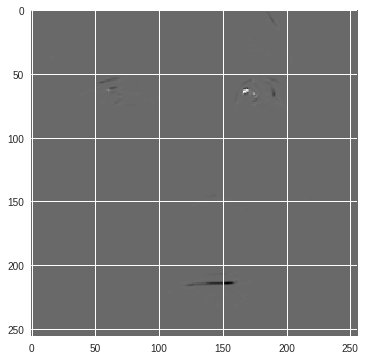

In [15]:
def HarrisCorner():
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/870_0.jpg')
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    corners = cv.cornerHarris(img_gray, 2, 3, 0.04)
    plt.figure(figsize=(6, 6))
    plt.imshow(corners, cmap='gray')
HarrisCorner()

In [16]:
face_list = []
face_files = os.listdir(SAVE_CROPPED_FACE_DIR)
for face_file_name in tqdm(face_files):
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/' + face_file_name)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    corners = cv.cornerHarris(img_gray, 2, 3, 0.04)
    face_list.append(corners)
face_list = np.asarray(face_list)

100%|██████████| 25/25 [00:00<00:00, 38.77it/s]


In [31]:
face_files

['4760_0.jpg',
 '4350_0.jpg',
 '4150_0.jpg',
 '3170_0.jpg',
 '3160_0.jpg',
 '2820_0.jpg',
 '2590_0.jpg',
 '2570_0.jpg',
 '2360_0.jpg',
 '2260_0.jpg',
 '2250_0.jpg',
 '1510_0.jpg',
 '880_0.jpg',
 '870_0.jpg',
 '840_0.jpg',
 '830_0.jpg',
 '780_0.jpg',
 '450_0.jpg',
 '300_0.jpg',
 '290_0.jpg',
 '280_1.jpg',
 '280_0.jpg',
 '270_1.jpg',
 '270_0.jpg',
 '260_0.jpg']

In [0]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_RANDOM_CENTERS
compactness, clusters, centers = cv.kmeans(face_list, 4, None, criteria, 10, flags)
# fig, ax = plt.subplots(2,5,figsize=(8,3))
# centers = centers.reshape(5,256,256)
# for axi, center in zip(ax.flat, centers):
#     axi.set(xticks=[], yticks=[])
#     axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
# plt.savefig('digits.png')

# import numpy as np
# from scipy.stats import mode
# labels = np.zeros_like(clusters.ravel())
# for i in range(10):
#     mask = (clusters.ravel() == i)
#     labels[mask] = mode(digits.target[mask])[0]

In [20]:
compactness, clusters, centers

(0.0004899100744069074, array([[2],
        [2],
        [2],
        [1],
        [0],
        [2],
        [2],
        [2],
        [2],
        [2],
        [3],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]], dtype=int32), array([[ 5.4256668e-07,  5.4256668e-07,  1.0380556e-07, ...,
         -2.0682637e-07,  6.6059665e-06,  4.2099347e-07],
        [ 3.3860493e-07,  3.3860493e-07,  6.5598852e-07, ...,
         -6.0347361e-08, -4.4998058e-07,  5.1850439e-08],
        [-1.2770530e-06, -1.2770530e-06, -3.7239242e-06, ...,
         -1.4728631e-10,  3.9743361e-11,  8.0484813e-11],
        [-3.7840717e-11, -3.7840717e-11, -1.5136287e-10, ...,
          6.2106089e-09, -3.3709169e-09, -1.3277135e-09]], dtype=float32))

100%|██████████| 9/9 [00:01<00:00,  5.36it/s]


Text(0,0.5,'compactness')

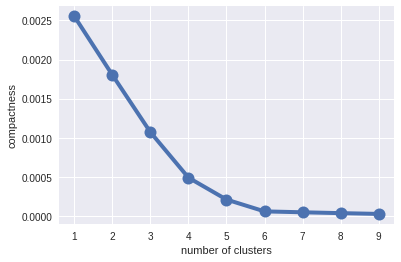

In [26]:
compactness = []
kvals = np.arange(1,10)
for k in tqdm(kvals):
    c, _, _ =  cv.kmeans(face_list, k, None, criteria, 10, flags)
    compactness.append(c)
plt.plot(kvals, compactness, 'o-', linewidth=4,
        markersize=12)
plt.xlabel('number of clusters')
plt.ylabel('compactness')

In [0]:
import shutil

In [35]:
# k = 5
# compactness, clusters, centers = cv.kmeans(face_list, k, None, criteria, 10, flags)
# make_directory(SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k))
# for i in range(k):
#     make_directory(SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k) + '/' + str(i))
# for f_n, c_k in tqdm(zip(face_files, clusters)):
#     shutil.copy2(SAVE_CROPPED_FACE_DIR + '/' + f_n, SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k) + '/' + str(c_k[0]) + '/' + f_n)
    
# compactness, clusters, centers

(0.00020967566314311625, array([[4],
        [4],
        [4],
        [3],
        [0],
        [4],
        [4],
        [4],
        [4],
        [1],
        [2],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4]], dtype=int32), array([[ 5.4256668e-07,  5.4256668e-07,  1.0380556e-07, ...,
         -2.0682637e-07,  6.6059665e-06,  4.2099347e-07],
        [ 1.6259644e-10,  1.6259644e-10,  9.2823732e-10, ...,
         -8.9141972e-11,  4.7786819e-10,  7.5215800e-10],
        [-3.7840717e-11, -3.7840717e-11, -1.5136287e-10, ...,
          6.2106089e-09, -3.3709169e-09, -1.3277135e-09],
        [ 3.3860493e-07,  3.3860493e-07,  6.5598852e-07, ...,
         -6.0347361e-08, -4.4998058e-07,  5.1850439e-08],
        [-1.3378727e-06, -1.3378727e-06, -3.9012980e-06, ...,
         -1.5005525e-10,  1.8886236e-11,  4.8500690e-11]], dtype=float32))

In [8]:
k = 6
compactness, clusters, centers = cv.kmeans(face_list, k, None, criteria, 10, flags)
make_directory(SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k))
for i in range(k):
    make_directory(SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k) + '/' + str(i))
for f_n, c_k in tqdm(zip(face_files, clusters)):
    shutil.copy2(SAVE_CROPPED_FACE_DIR + '/' + f_n, SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k) + '/' + str(c_k[0]) + '/' + f_n)
    
compactness, clusters, centers

NameError: ignored

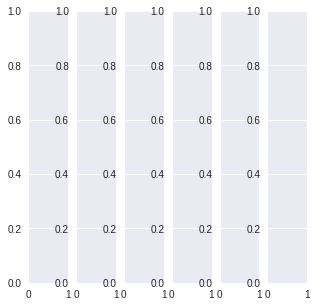

In [6]:
fig, ax = plt.subplots(1,6,figsize=(5,5))

In [7]:
centers.shape

NameError: ignored